# Fashion MNIST Image Classification - ML Project

Authors: Ivan Kulazhenkov, Andres Aranguren

Website reference: https://github.com/zalandoresearch/fashion-mnist

In [58]:
##################################################
# Imports
##################################################

import numpy as np
import cv2
import os
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold




##################################################
# Params
##################################################

DATA_BASE_FOLDER = '/kaggle/input/image-classification-fashion-mnist'

# Hyperparameters
batch = 32
EPOCHS = 20
learning_rate= 0.01
momentum = 0.9


# Define a callback function in order to interrupt model evaluation when specified metric does not improve
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Dataset

The dataset contains 50k train + 10k validation images of 10 different categories ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot').

Each image is a 28x28 grayscale, and for simplicity here is flattened into a 784 dimensional vector.

Number of classes 10


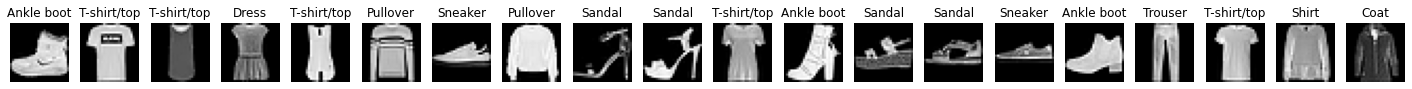

In [3]:
##################################################
# Load dataset
##################################################

#Dataset import and variable assignment
x_train = np.load(os.path.join(DATA_BASE_FOLDER, 'train.npy'))
x_valid = np.load(os.path.join(DATA_BASE_FOLDER, 'validation.npy'))
x_test = np.load(os.path.join(DATA_BASE_FOLDER, 'test.npy'))
y_train = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'train.csv'))['class'].values
y_valid = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'validation.csv'))['class'].values

# Number of labels that we have in our dataset
y_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(y_labels)
print('Number of classes',num_classes)

# Plot random images of different classes
plt.figure(figsize=(25, 5))
for idx in range(20):
    plt.subplot(1, 20, idx + 1)
    img = x_train[idx].reshape(28, 28)
    plt.title(f'{y_labels[y_train[idx]]}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

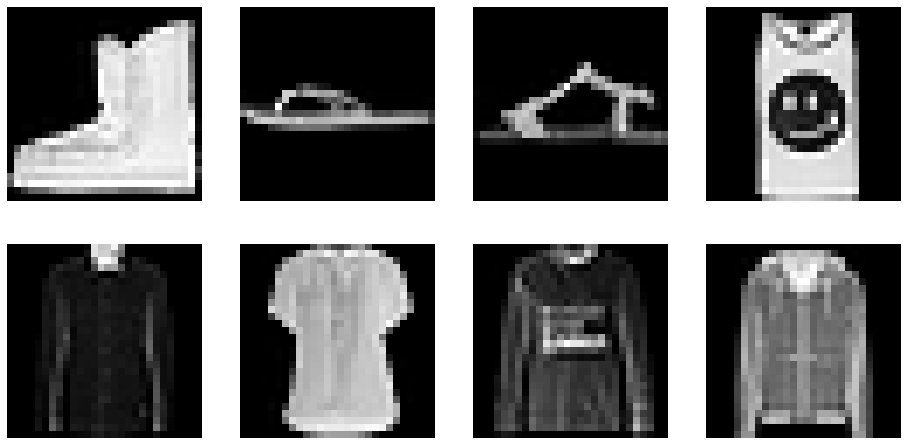

In [4]:
##################################################
# Data Processing and Exploration
##################################################

'''
In addition to our linear models we are also using a 2D convolutional neural network for classifcation.
Here we are doing a resize of our linear data into 28x28 2D matrix
'''
x_train_2d = x_train.reshape(50000,28,28)
x_valid_2d = x_valid.reshape(10000,28,28)
x_test_2d = x_test.reshape(10000,28,28)


## visualize an example of some 2d training images

nrows = 2
ncols = 4
fig = plt.gcf()
fig.set_size_inches(ncols*4,nrows*4)

n_imgs = nrows*ncols
for i in range(n_imgs):
    sp = plt.subplot(nrows,ncols,i+1)
    sp.axis('Off')
    plt.imshow(x_train_2d[i+random.randint(1,100)],cmap=plt.get_cmap('gray'))
plt.show()


# Model Implementation

Here you have to implement a model (or more models, for finding the most accurate) for classification.

You can use the [`sklearn`](https://scikit-learn.org/stable/) (or optionally other more advanced frameworks such as [`pytorch`](https://pytorch.org/) or [`tensorflow`](https://www.tensorflow.org/)) package that contains a pool of models already implemented that perform classification. (SVMs, NNs, LR, kNN, ...)**




# Implementation of our 1D data models
*  We have implemented 3  machine learning models including (Logistic Regression, KNN, Random Forest and NN) to run on linear data.
*  We also attempted to implement an SVM. However, the run time was extremely slow so we avoided it. 
*  For comparison running on a smaller sample size gave us an accuracy of just under 70%. This was significantly worse than our best model.


In [ ]:
# Logistic Regression Model
# For the logistic regression model we will be using the sag(stochastic average gradient) solver and 10x more iterations than default.
# We allow the model to automatically configure for a multi class problem.
# We use the sag solver priamrily for efficiency's sake.(It still takes ~30 mins to fit)

lr = LogisticRegression(solver='sag', max_iter=1000)
lr.fit(x_train, y_train)


# Logistic Regression prediction and report 

y_pred_lr = lr.predict(x_valid)
print('Logistic Regression Metrics')
print(metrics.classification_report(y_valid, y_pred_lr))

In [ ]:
# KNN Model
# We left the model as default other than the number of neighbours to consider.
# After testing several values we did not notice significant differences.
# As such we left the parameter at our original 7.

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)


#KNN prediction on the validation set(longest part of the model takes about ~13 mins)

y_pred_knn = knn.predict(x_valid)


# KNN table of results

print('KNN Metrics')
print(metrics.classification_report(y_valid, y_pred_knn))

In [ ]:
# Random Forest
# We left most of the RF model as stock other than specifying the criterion,depth and verbose output

rf = RandomForestClassifier(criterion='gini', max_depth=80, verbose=1)
rf.fit(x_train, y_train)


# Random Forest predictions and table of results
# Here we run predictions on the validation set and output a classification report

y_pred_forest = rf.predict(x_valid)

print('Random Forest Metrics')
print(metrics.classification_report(y_valid, y_pred_forest))

## Neural networks approach

#### We define the functions required for the baseline used for model construction evaluation and prediction

In [5]:
## Function used to evaluate the model implementing k fold cross validation 

def evaluate_model(dataX, dataY, model,n_folds):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        #model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories




In [6]:
# Function used to plot diagnostic learning curves when using k fold cross validation
def k_fold_summarize_diagnostics(histories):
    for i in range(len(histories)):
        fig, axs = plt.subplots(1,2, figsize = [19,5])
        axs[0].set_title('Cross Entropy Loss')
        axs[0].plot(histories[i].history['loss'], color='blue', label='train')
        axs[0].plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
    
        axs[1].set_title('Classification Accuracy')
        axs[1].plot(histories[i].history['accuracy'], color='blue', label='train')
        axs[1].plot(histories[i].history['val_accuracy'], color='orange', label='test')
        _ = axs[1].legend(['Training', 'Validation'], loc='upper left')


In [72]:
# Function used to plot diagnostic learning curves

def summarize_diagnostics(histories,model_name):
    acc = histories.history['accuracy']
    val_acc = histories.history['val_accuracy']
    temp_epoch = len(acc)

    loss = histories.history['loss']
    val_loss = histories.history['val_loss']


    fig, axs = plt.subplots(2,1, figsize = [10,10])
    fig.suptitle(model_name)
    axs[0].plot(range(temp_epoch),loss,lw=3,label='Training loss')
    axs[0].plot(range(temp_epoch),val_loss,lw=3,label='Validation loss')
    axs[0].grid()
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_title('Cross Entropy Loss')
    _ = axs[0].legend(['Training', 'Validation'], loc='upper right')

    axs[1].plot(range(temp_epoch),acc,lw=3,label='Training Accuracy')
    axs[1].plot(range(temp_epoch),val_acc,lw=3,label='Validation Accuracy')
    axs[1].grid()
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_title('Classification Accuracy',)
    _ = axs[1].legend(['Training', 'Validation'], loc='upper left')
    

In [8]:
def eval_correct(predicted_values,true_labels):
    corr = 0
    for i in range(len(true_labels)):
        if predicted_values[i]==true_labels[i]:
            corr+=1
    print('Correct predictions:',corr)
    print('Incorrect predictions',len(true_labels)-corr)
    print('Predictions accuracy:',corr/len(true_labels))

## CNN Models building
* We have implemented 4 different Convolutional Neural Network(CNN) machine learning models.
* CNN Model 1 created with a single conv2d layer
* CNN Model 2 triple layer network with dropout regularization
* CNN Model 3 takes model 2 and adds Gaussian Noise as well as Batch Normalization
* CNN Model 4 takes the augmentations from three and adds an expansion Conv2d/MaxPool2d layer pair

In [11]:
model_cnn_1 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dense(10,activation='softmax')])

In [12]:
model_cnn_2 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(10,activation='softmax')])

In [13]:
model_cnn_3 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.GaussianNoise(0.1),
                                    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.GaussianNoise(0.1),
                                    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(10,activation='softmax')])

In [44]:
model_cnn_4 = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),padding='same',activation='relu',input_shape=(28,28,1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.GaussianNoise(0.1),
                                    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Conv2D(128,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.MaxPool2D(2,2),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.GaussianNoise(0.1),
                                    tf.keras.layers.Conv2D(256,(3,3),padding='same',activation='relu'),
                                    tf.keras.layers.Dropout(0.25),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128,activation='relu'),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(10,activation='softmax')])

## Compile models

In [45]:
#Compile the models using adam optimizers, categorical crossentropy since it is a multiclass label 
#problem
model_cnn_1.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


model_cnn_2.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


model_cnn_3.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


model_cnn_4.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


In [46]:
'''
First of all we convert our 2d image data into a 4 dimensional array.
This is done so that keras can understand that the images are grayscale

'''
x_train_2d = x_train_2d.reshape(50000,28,28,1)
x_valid_2d = x_valid_2d.reshape(10000,28,28,1)
x_test_2d  = x_test_2d.reshape(10000,28,28,1)

## Simple Neural Network 1 layer (NN)

Understanding initial keras neural network model and testing various activation functions

In [39]:
#How many and which activation functions we are planning to test
activations = {'relu':tf.nn.relu,'tanh':tf.nn.tanh,'sigmoid':tf.nn.sigmoid}

In [20]:
#In the following two for loops we define and run a total of 3 models.
#These are each using one of the activation functions that has been defined above

models= {'activation':[],'model':[]}
for a in list(activations.keys()):
    temp = tf.keras.Sequential([tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128,activation=activations[a] ),
                             tf.keras.layers.Dense(10,activation=tf.nn.softmax)])
    models['activation'].append(a)
    models['model'].append(temp)
    

    
#We then store each history of the models fit into a histories value.
#This is then used to graphically represent the performance of each model
histories = []

for i in models['model']:
    i.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
    mfit = i.fit(x_train,
          y_train,
          validation_data = (x_valid,y_valid),
          epochs=EPOCHS,
          batch_size=batch)
    histories.append(mfit)
    
    


{'activation': ['relu', 'tanh', 'sigmoid'], 'model': [<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f91da76d1d0>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f91d014f490>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f91da76d9d0>]}
Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 6s 119us/sample - loss: 3.6928 - accuracy: 0.7056 - val_loss: 0.7915 - val_accuracy: 0.7467
Epoch 2/20
50000/50000 [==============================] - 6s 113us/sample - loss: 0.6659 - accuracy: 0.7820 - val_loss: 0.6617 - val_accuracy: 0.7864
Epoch 3/20
50000/50000 [==============================] - 5s 109us/sample - loss: 0.5814 - accuracy: 0.8021 - val_loss: 0.5405 - val_accuracy: 0.8149
Epoch 4/20
50000/50000 [==============================] - 6s 121us/sample - loss: 0.5354 - accuracy: 0.8140 - val_loss: 0.6569 - val_accuracy: 0.7475
Epoch 5/20
50000/50000 [============================

Epoch 13/20
50000/50000 [==============================] - 5s 97us/sample - loss: 0.6470 - accuracy: 0.7539 - val_loss: 0.6634 - val_accuracy: 0.7362
Epoch 14/20
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6518 - accuracy: 0.7582 - val_loss: 0.6439 - val_accuracy: 0.7619
Epoch 15/20
50000/50000 [==============================] - 5s 91us/sample - loss: 0.6383 - accuracy: 0.7606 - val_loss: 0.6345 - val_accuracy: 0.7599
Epoch 16/20
50000/50000 [==============================] - 4s 86us/sample - loss: 0.6074 - accuracy: 0.7649 - val_loss: 0.6074 - val_accuracy: 0.7777
Epoch 17/20
50000/50000 [==============================] - 4s 87us/sample - loss: 0.6333 - accuracy: 0.7625 - val_loss: 0.6295 - val_accuracy: 0.7742
Epoch 18/20
50000/50000 [==============================] - 4s 89us/sample - loss: 0.6375 - accuracy: 0.7595 - val_loss: 0.6489 - val_accuracy: 0.7572
Epoch 19/20
50000/50000 [==============================] - 4s 85us/sample - loss: 0.6569 - accuracy:

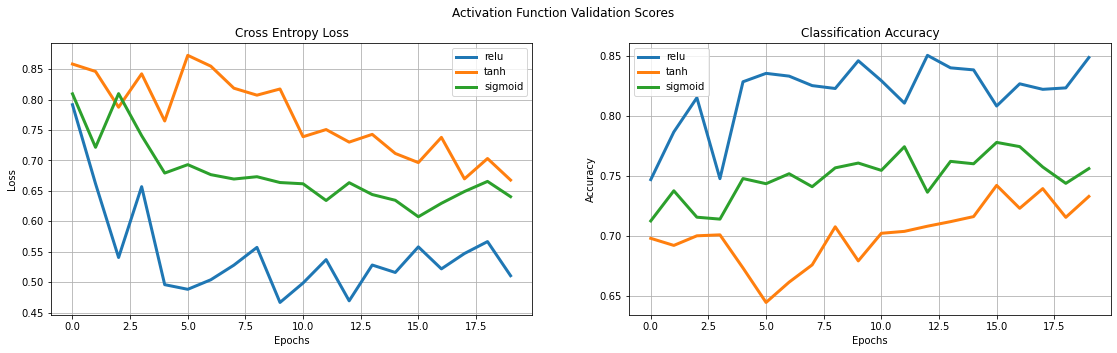

In [42]:
#Plot creation to plot model and its respective activation function.
#We show the validation accuracy and loss for each one


fig, axs = plt.subplots(1,2, figsize = [19,5])
fig.suptitle('Activation Function Validation Scores')
for i in range(len(histories)):
    label = list(activations.keys())[i]


    
    
    #axs[0].plot(range(temp_epoch),histories[i].history['loss'],lw=3,label='Training loss')
    axs[0].plot(range(temp_epoch),histories[i].history['val_loss'],lw=3,label=label)
    axs[0].grid()
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_title('Cross Entropy Loss')
    _ = axs[0].legend(['Validation'], loc='upper right')
axs[0].legend()

for i in range(len(histories)):
    label = list(activations.keys())[i]

    #axs[1].plot(range(temp_epoch),histories[i].history['accuracy'],lw=3,label='Training Accuracy')
    axs[1].plot(range(temp_epoch),histories[i].history['val_accuracy'],lw=3,label=label)
    axs[1].grid()
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_title('Classification Accuracy',)
    _ = axs[1].legend(['Validation'], loc='upper left')

axs[1].legend()

plt.show()    


# Implementation of our CNN models



## CNN Model 1

In [ ]:
# First Simple CNN implementatiobn 

history_cnn_1 = model_cnn_1.fit(
    x_train_2d,
    y_train,
    epochs=EPOCHS,
    batch_size=batch,
    validation_data = (x_valid_2d,y_valid),
    callbacks=[callback]
    )




In [ ]:
# First Simple CNN Prediction and Output Report

y_pred_cnn_1 = model_cnn_1.predict_classes(x_valid_2d)

print('\nSimple CNN metrics')
print(metrics.classification_report(y_pred_cnn_1,y_valid))

In [ ]:
eval_correct(y_pred_cnn_1,y_valid)

## CNN Model 2

In [ ]:
#model_cnn_2.summary()


history_cnn_2 = model_cnn_2.fit(
    x_train_2d,
    y_train,
    epochs=EPOCHS,
    batch_size=batch,
    validation_data = (x_valid_2d,y_valid)
    #callbacks=[callback]
    )


In [ ]:
y_pred_cnn_2 = model_cnn_2.predict_classes(x_valid_2d)
print('Convolutional Neural Network_2')
print(metrics.classification_report(y_pred_cnn_2,y_valid))

In [ ]:
eval_correct(y_pred_cnn_2,y_valid)

In [ ]:
summarize_diagnostics(history_cnn_2,'CNN_2')

## CNN Model 3

In [80]:
history_cnn_3 = model_cnn_3.fit(
    x_train_2d,
    y_train,
    epochs=EPOCHS,
    batch_size=batch,
    validation_data = (x_valid_2d,y_valid)
    #callbacks=[callback]
    )


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 174us/sample - loss: 0.5792 - accuracy: 0.7926 - val_loss: 0.3688 - val_accuracy: 0.8617
Epoch 2/20
50000/50000 [==============================] - 8s 160us/sample - loss: 0.3998 - accuracy: 0.8542 - val_loss: 0.3226 - val_accuracy: 0.8830
Epoch 3/20
50000/50000 [==============================] - 7s 142us/sample - loss: 0.3655 - accuracy: 0.8674 - val_loss: 0.3137 - val_accuracy: 0.8810
Epoch 4/20
50000/50000 [==============================] - 8s 155us/sample - loss: 0.3422 - accuracy: 0.8753 - val_loss: 0.2972 - val_accuracy: 0.8917
Epoch 5/20
50000/50000 [==============================] - 7s 143us/sample - loss: 0.3255 - accuracy: 0.8815 - val_loss: 0.2980 - val_accuracy: 0.8924
Epoch 6/20
50000/50000 [==============================] - 7s 139us/sample - loss: 0.3151 - accuracy: 0.8854 - val_loss: 0.2672 - val_accuracy: 0.8988
Epoch 7/20
50000/50000 [==========================

Convolutional Neural Network_3
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       999
           1       0.98      0.99      0.99       977
           2       0.82      0.90      0.86       909
           3       0.92      0.93      0.93      1009
           4       0.86      0.86      0.86      1059
           5       0.98      0.99      0.98       988
           6       0.79      0.70      0.74      1102
           7       0.98      0.94      0.96       989
           8       0.99      0.98      0.98       971
           9       0.96      0.98      0.97       997

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.91      0.92      0.91     10000

Correct predictions: 9152
Incorrect predictions 848
Predictions accuracy: 0.9152


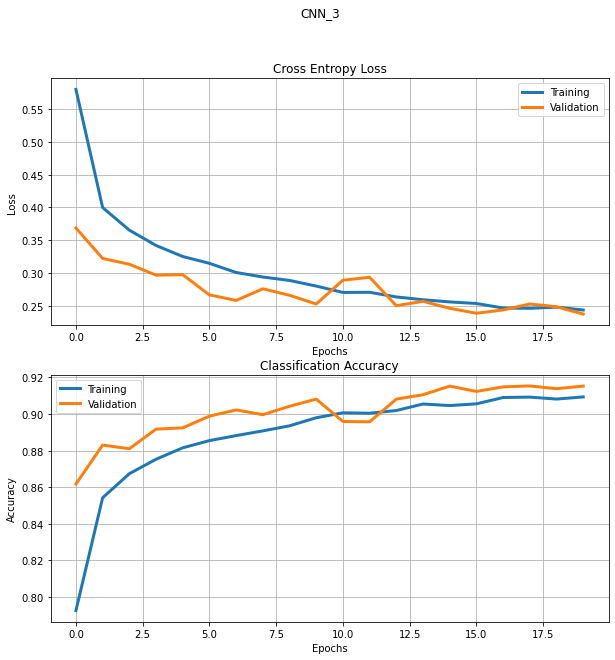

In [81]:
y_pred_cnn_3 = model_cnn_3.predict_classes(x_valid_2d)
print('Convolutional Neural Network_3')
print(metrics.classification_report(y_pred_cnn_3,y_valid))

eval_correct(y_pred_cnn_3,y_valid)

summarize_diagnostics(history_cnn_3,'CNN_3')

## Visualization of intermediate steps of final CNN Model 4

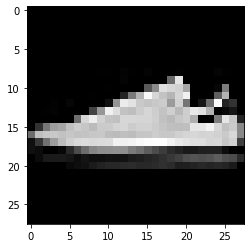

In [74]:
in_im = x_train[6]
test_im = x_train[6].reshape((28,28))
plt.imshow(test_im,cmap='gray')
plt.show()

In [75]:
ev_image= test_im.reshape((1,) + test_im.shape) 
ev_image = ev_image.reshape(1,28,28,1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


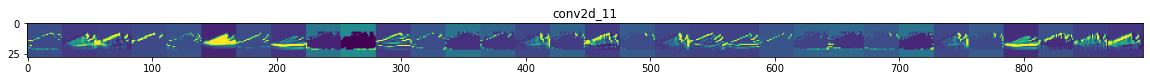

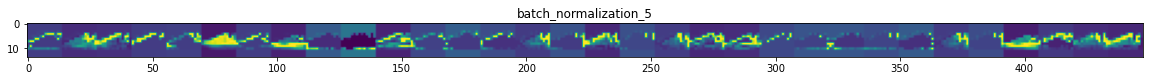

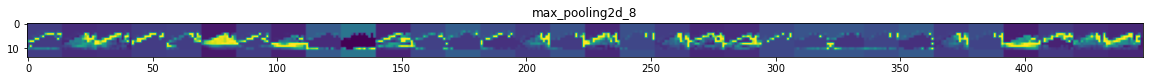

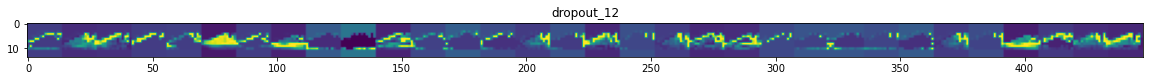

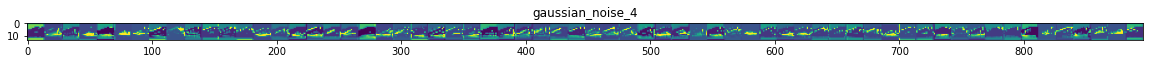

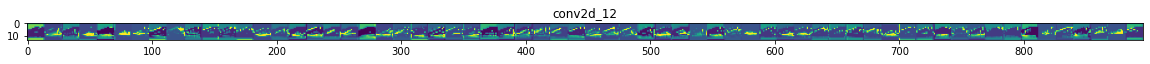

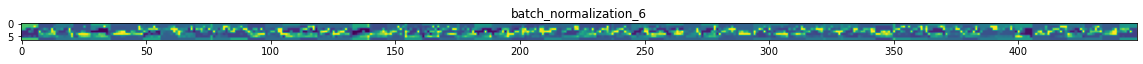

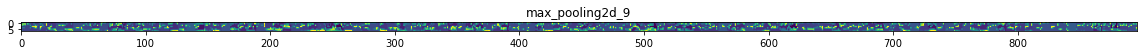

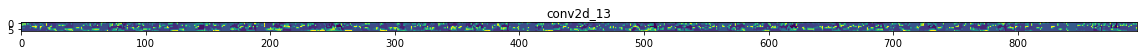

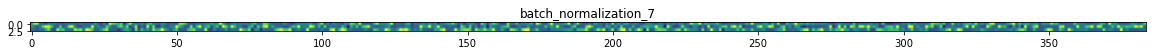

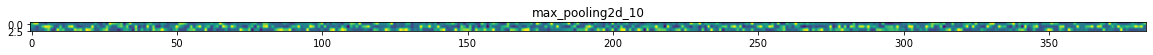

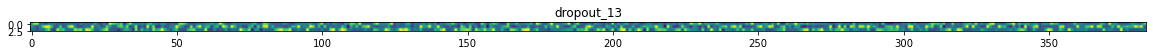

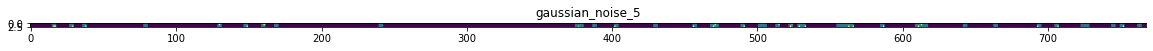

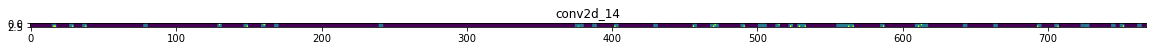

In [76]:
##################################################
# CNN 2 Visualization example 
##################################################


#ev_image = in_im.reshape((1,) + in_im.shape) 

successive_outputs = [layer.output for layer in model_cnn_4.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model_cnn_4.input, outputs = successive_outputs)
#x   = img_to_array(ev_image)
successive_feature_maps = visualization_model.predict(ev_image)
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model_cnn_4.layers]
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

## FINAL: CNN Model 4 and Result Analysis

In [51]:
history_cnn_4 = model_cnn_4.fit(
    x_train_2d,
    y_train,
    epochs=EPOCHS,
    batch_size=batch,
    validation_data = (x_valid_2d,y_valid)
    )


Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 218us/sample - loss: 0.5056 - accuracy: 0.8166 - val_loss: 0.3574 - val_accuracy: 0.8624
Epoch 2/20
50000/50000 [==============================] - 9s 185us/sample - loss: 0.3639 - accuracy: 0.8668 - val_loss: 0.3078 - val_accuracy: 0.8878
Epoch 3/20
50000/50000 [==============================] - 9s 176us/sample - loss: 0.3218 - accuracy: 0.8854 - val_loss: 0.2690 - val_accuracy: 0.9046
Epoch 4/20
50000/50000 [==============================] - 8s 167us/sample - loss: 0.2948 - accuracy: 0.8941 - val_loss: 0.2628 - val_accuracy: 0.9078
Epoch 5/20
50000/50000 [==============================] - 9s 190us/sample - loss: 0.2858 - accuracy: 0.8972 - val_loss: 0.3201 - val_accuracy: 0.8820
Epoch 6/20
50000/50000 [==============================] - 9s 172us/sample - loss: 0.2687 - accuracy: 0.9048 - val_loss: 0.2662 - val_accuracy: 0.9049
Epoch 7/20
50000/50000 [=========================

Convolutional Neural Network_4
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1048
           1       0.99      1.00      0.99       975
           2       0.87      0.91      0.89       960
           3       0.96      0.92      0.94      1066
           4       0.91      0.86      0.88      1114
           5       0.98      0.99      0.98       983
           6       0.77      0.84      0.80       897
           7       0.99      0.93      0.96      1018
           8       0.99      0.99      0.99       968
           9       0.95      0.99      0.97       971

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Correct predictions: 9309
Incorrect predictions 691
Predictions accuracy: 0.9309


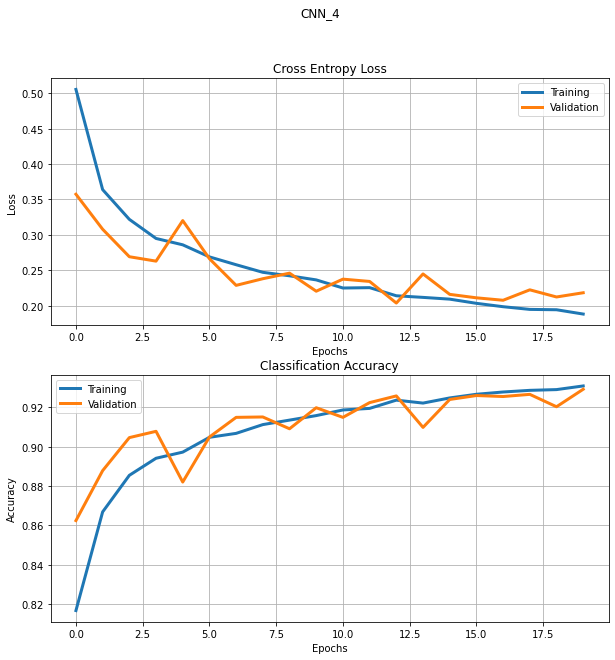

In [73]:
y_pred_cnn_4 = model_cnn_4.predict_classes(x_valid_2d)
print('Convolutional Neural Network_4')
print(metrics.classification_report(y_pred_cnn_4,y_valid))

eval_correct(y_pred_cnn_4,y_valid)

summarize_diagnostics(history_cnn_4,'CNN_4')

## Confusion Matrix

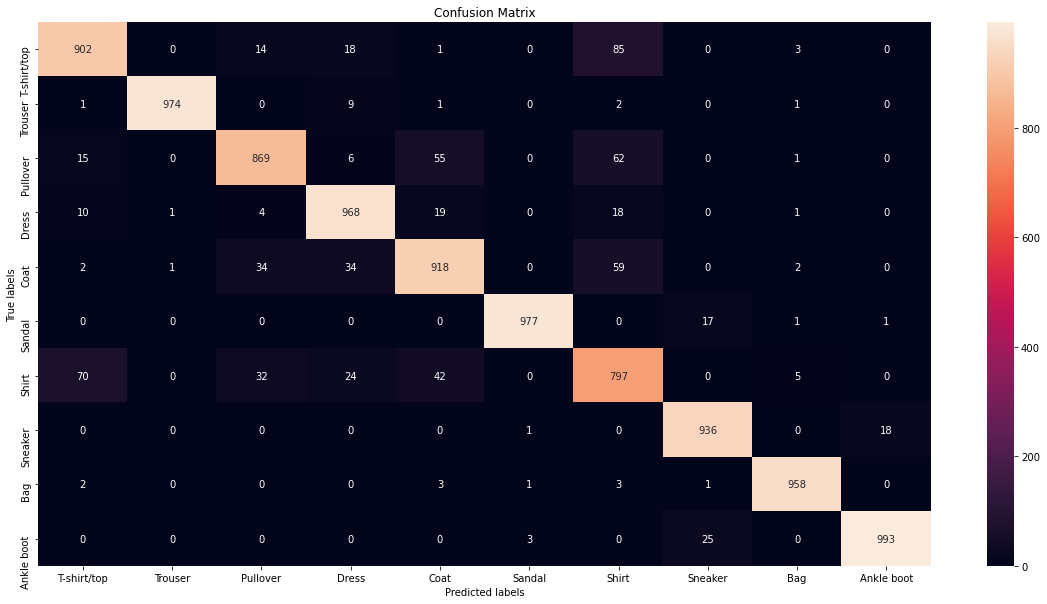

In [53]:
cnn_cm = metrics.confusion_matrix(y_valid,y_pred_cnn_4)
f, ax= plt.subplots(figsize=(20,10))

sns.heatmap(cnn_cm, annot=True, ax = ax,fmt='d') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(y_labels); ax.yaxis.set_ticklabels(y_labels);

## Final CNN evaluation using k-fold Cross-Validation

5-fold Cross-Validation done on CNN model 4

In [78]:
scores, histories = evaluate_model(x_train_2d,y_train,model_cnn_4,10)

> 96.860
> 97.260
> 96.480
> 97.620
> 97.580
> 98.100
> 97.240
> 97.920
> 98.220
> 97.960


We then take the average for our final cross-validation score

In [79]:
average = np.mean(scores)*100
print(average)

97.52399325370789


# Send the submission for the challenge

In [77]:
##################################################
# Save your test prediction in y_test_pred
##################################################

y_test_pred = model_cnn_4.predict_classes(x_test_2d)

# Create submission
submission = pd.read_csv(os.path.join(DATA_BASE_FOLDER, 'sample_submission.csv'))
if y_test_pred is not None:
    submission['class'] = y_test_pred
submission.to_csv('my_submission.csv', index=False)

# Appendix

In [ ]:
# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax) #annot=True to annotate cells

# # labels, title and ticks
# ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(y_labels); ax.yaxis.set_ticklabels(y_labels);



# import scikitplot as skplt

# skplt.metrics.plot_confusion_matrix(
#     y_true, 
#     y_pred,
#     figsize=(12,12))

In [ ]:
# ##################################################
# # Implement you model here 2D 1conv
# ##################################################

# model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1)),
#                                     tf.keras.layers.MaxPool2D(2,2),
#                                     tf.keras.layers.Flatten(),
#                                     tf.keras.layers.Dense(256,activation='relu'),
#                                     tf.keras.layers.Dense(10,activation='softmax')])
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.fit(x_train,y_train,epochs=5)
# model.evaluate(x_test,y_test)

# model.summary()

In [ ]:
# ##################################################
# # Implement you model here 2D 2conv
# ##################################################
# model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1)),
#                                     tf.keras.layers.MaxPool2D(2,2),
#                                     tf.keras.layers.Conv2D(64,(3,3)),
#                                     tf.keras.layers.MaxPool2D(2,2),
#                                     tf.keras.layers.Flatten(),
#                                     tf.keras.layers.Dense(128,activation='relu'),
#                                     tf.keras.layers.Dense(10,activation='softmax')])
# model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
# model.fit(x_train,y_train,epochs=5)
# model.evaluate(x_test,y_test)

# model.summary()


In [ ]:
#scores, histories = evaluate_model(x_train_2d,y_train,model_cnn_3,5)